In [1]:
from gptopt.optim.attn_kq import * 
from utils_pdhg import *

/mnt/home/tparshakova/Documents/GPT-opt/venv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch

from gptopt.utils import set_seed
set_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Comparison of methods to solve
$$
\begin{array}{ll}
{\text{minimize}} &  
\langle G_1, Z_1 \rangle + \langle G_2, Z_2 \rangle + h(X) \\ 
\text{subject to} & X = Z_1^\top B + A^\top Z_2
\end{array} 
$$

## PDHG
$$
\begin{aligned}
Y^{t+1} &= \operatorname{prox}_{\rho h^*}(Y^t + \rho 
((2Z_1^t - Z_1^{t-1})^\top B  + A^\top (2Z_2^t - Z_2^{t-1})))\\
\begin{bmatrix}
    Z_1^{t+1} \\ Z_2^{t+1}
\end{bmatrix} &=  \begin{bmatrix}
    Z_1^t \\ Z_2^t
\end{bmatrix} - \gamma \left (
\begin{bmatrix}
    B(Y^{t+1})^\top \\ AY^{t+1}
\end{bmatrix}
+ \begin{bmatrix}
    G_1 \\ G_2
\end{bmatrix} \right )  
\end{aligned}
$$


In [3]:
n_layer = 4
std1 = 0.02 / np.sqrt(2.0 * n_layer)
std2 = 0.01
rank_ratio = 0.7
max_iter = 1000

betas = [ 1e-3, 5e-4, 1e-4]

#  $m=n=50$

In [4]:
m = n = 50
A, B, G1, G2, A_np, B_np, G1_np, G2_np, lamb_max = gaussian_data(m, n, std1=1, std2=1, 
                                                                 rank_ratio=rank_ratio, G_in_range=True)
beta = 0.01

mu_reg = 0
nA = A.pow(2).sum().sqrt().item()
nB = B.pow(2).sum().sqrt().item()
lamb_max = (nA * nA + nB * nB) ** 0.5

print(f"{lamb_max=:.4e}")

lamb_max=7.0456e+01


In [5]:
Z_star_1, Z_star_2, f_star, Y_star = cvxpy_AB(G1_np, G2_np, A_np, B_np, beta, mu=mu_reg, verbose=False)

In [7]:
Y_star_torch = torch.tensor(Y_star, dtype=A.dtype, device=device)
Z_star_1_torch = torch.tensor(Z_star_1, dtype=A.dtype, device=device)
Z_star_2_torch = torch.tensor(Z_star_2, dtype=A.dtype, device=device)
pd_residuals_infty_ball(A, B, Y_star_torch, Z_star_1_torch, Z_star_2_torch, G1, G2, beta, mu_reg)

(5.820902515552007e-07,
 1.1641805031104013e-06,
 1.425727458747669e-06,
 4.053301069674147e-07)

In [8]:
Y0, res_y = Y_dual_feasible(A1=B, A2=A, G1=G1, G2=G2, method="lsqr", maxit=1000) 
(Z1_0, Z2_0), res_z = attn_least_squares_solve(A1=B, A2=A, G1=G1, G2=G2, X_type="Z", Y0=Y0, beta=beta, 
                                                tol=1e-10, maxit=1000, diag_scaling=True)
res_y["res"], res_z["res"]

(1.1314976059431856e-06, 3.0602516289945925e-06)

In [9]:
# Torch prox for h* (uses prox_l1 from pdhg.py)
prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
h_conj = lambda y: beta * torch.abs(y).sum()

In [10]:
func_obj = lambda Z1, Z2: (torch.trace(G1.T @ Z1) + torch.trace(G2.T @ Z2)).item()  
func_constr_viol = lambda Z1, Z2: max(torch.max(torch.abs(Z1.T @ B + A.T @ Z2)).item() - beta, 0) / beta

In [13]:
print(
    f"{f_star=:.4e}, "
    f"{func_obj(torch.from_numpy(Z_star_1).to(G1), torch.from_numpy(Z_star_2).to(G2))}, "
    f"\ncvxpy constraint violation: "
    f"{func_constr_viol(torch.from_numpy(Z_star_1).to(G1), torch.from_numpy(Z_star_2).to(G2))}"
)
print(pd_residuals_infty_ball(A=A, B=B, Y=torch.from_numpy(Y_star).to(G1.dtype).to(G1.device), 
                              Z1=torch.from_numpy(Z_star_1).to(G1.dtype).to(G1.device), 
                              Z2=torch.from_numpy(Z_star_2).to(G1.dtype).to(G1.device), 
                                      G1=G1, G2=G2, beta=beta, mu=0))

f_star=-5.0294e-01, -0.5029401779174805, 
cvxpy constraint violation: 6.295740604192468e-07
(5.820902515552007e-07, 1.1641805031104013e-06, 1.425727458747669e-06, 4.053301069674147e-07)


In [12]:
residuals = compare_methods_fast_pdhg(prox_h_conj, h_conj, A, B, G1, G2, beta, mu_reg, f_star=f_star, 
                            stopping=False, max_iter=1000, eps_abs=1e-5)

Method                 Obj          Viol
----------------------------------------
pdhg          -5.035380e-01  7.684639e-01
rehpdhg       -5.608988e-01  3.496439e-01
pdhg ds       -5.029100e-01  6.194239e-01
rehpdhg ds    -5.666664e-01  3.815301e-01
ada rehpdhg   -5.028758e-01  1.360818e-02
ada rehpdhg ds  -5.029128e-01  1.920497e-02


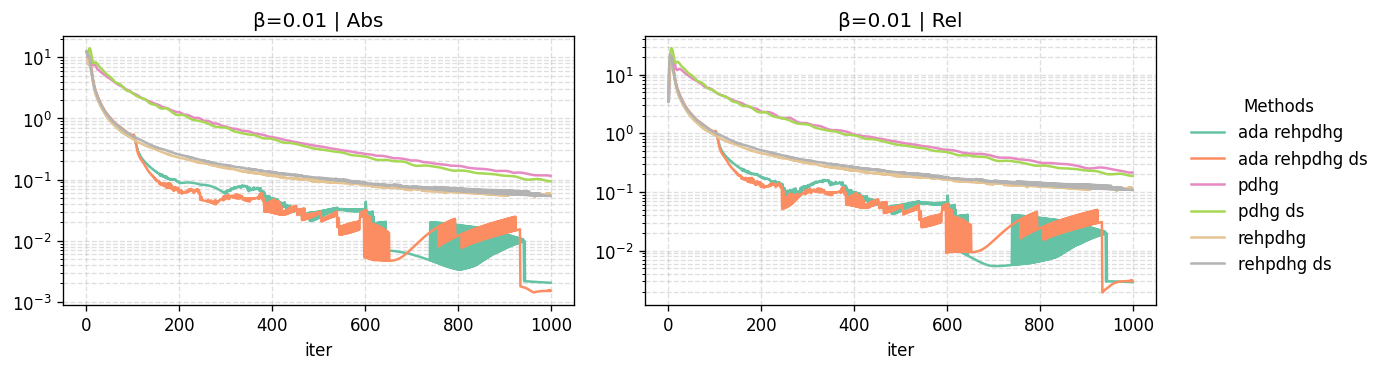

In [14]:
_ = plot_residuals_grid_by_param({beta:residuals}, 
                                #  abs_ylim=(1e-3, 5), rel_ylim=(1e-4, 1.5), 
                                 param_name='beta')

In [15]:
# cupdlp r1 is large probably due to rounding of Y and the corresponding sign(Y) 

#  $m=n=1000$

In [16]:
m = n = 1000
std2 = 1 
rank_ratio = 0.5
A, B, G1, G2, A_np, B_np, G1_np, G2_np, lamb_max = gaussian_data(m, n, std1=std1, std2=std2, 
                                                                 rank_ratio=rank_ratio, G_in_range=True)

lamb_max = (A.pow(2).sum().sqrt().item() + B.pow(2).sum().sqrt().item()) ** 0.5

print(f"{lamb_max=:.4e}")

lamb_max=3.7619e+00


In [17]:
residuals = {}
for beta in betas:
    # Torch prox for h* (uses prox_l1 from pdhg.py)
    prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
    h_conj = lambda y: beta * torch.abs(y).sum()

    mu_reg = 0
    print(f"{beta=}, {lamb_max=:.4e}")
    residuals[beta] = compare_methods_fast_pdhg(prox_h_conj, h_conj, A, B, G1, G2, beta, mu_reg, f_star=None, 
                            stopping=False, max_iter=max_iter, eps_abs=1e-6)

beta=0.001, lamb_max=3.7619e+00
Method                 Obj          Viol
----------------------------------------
pdhg          -9.733663e-01  4.129799e-01
rehpdhg       -9.807405e-01  6.127420e-02
pdhg ds       -9.847102e-01  4.132962e-01
rehpdhg ds    -9.931282e-01  6.154033e-02
ada rehpdhg   -9.644994e-01  6.374198e-02
ada rehpdhg ds  -9.767771e-01  5.490512e-02
beta=0.0005, lamb_max=3.7619e+00
Method                 Obj          Viol
----------------------------------------
pdhg          -4.933851e-01  7.082754e-01
rehpdhg       -5.008919e-01  8.698709e-02
pdhg ds       -4.961668e-01  6.943011e-01
rehpdhg ds    -5.049765e-01  8.090532e-02
ada rehpdhg   -4.921387e-01  6.589217e-02
ada rehpdhg ds  -4.950224e-01  5.170021e-02
beta=0.0001, lamb_max=3.7619e+00
Method                 Obj          Viol
----------------------------------------
pdhg          -1.573171e-02  0.000000e+00
rehpdhg       -1.076273e-01  3.241191e-01
pdhg ds       -2.764932e-02  3.214487e-01
rehpdhg ds    -1.08837

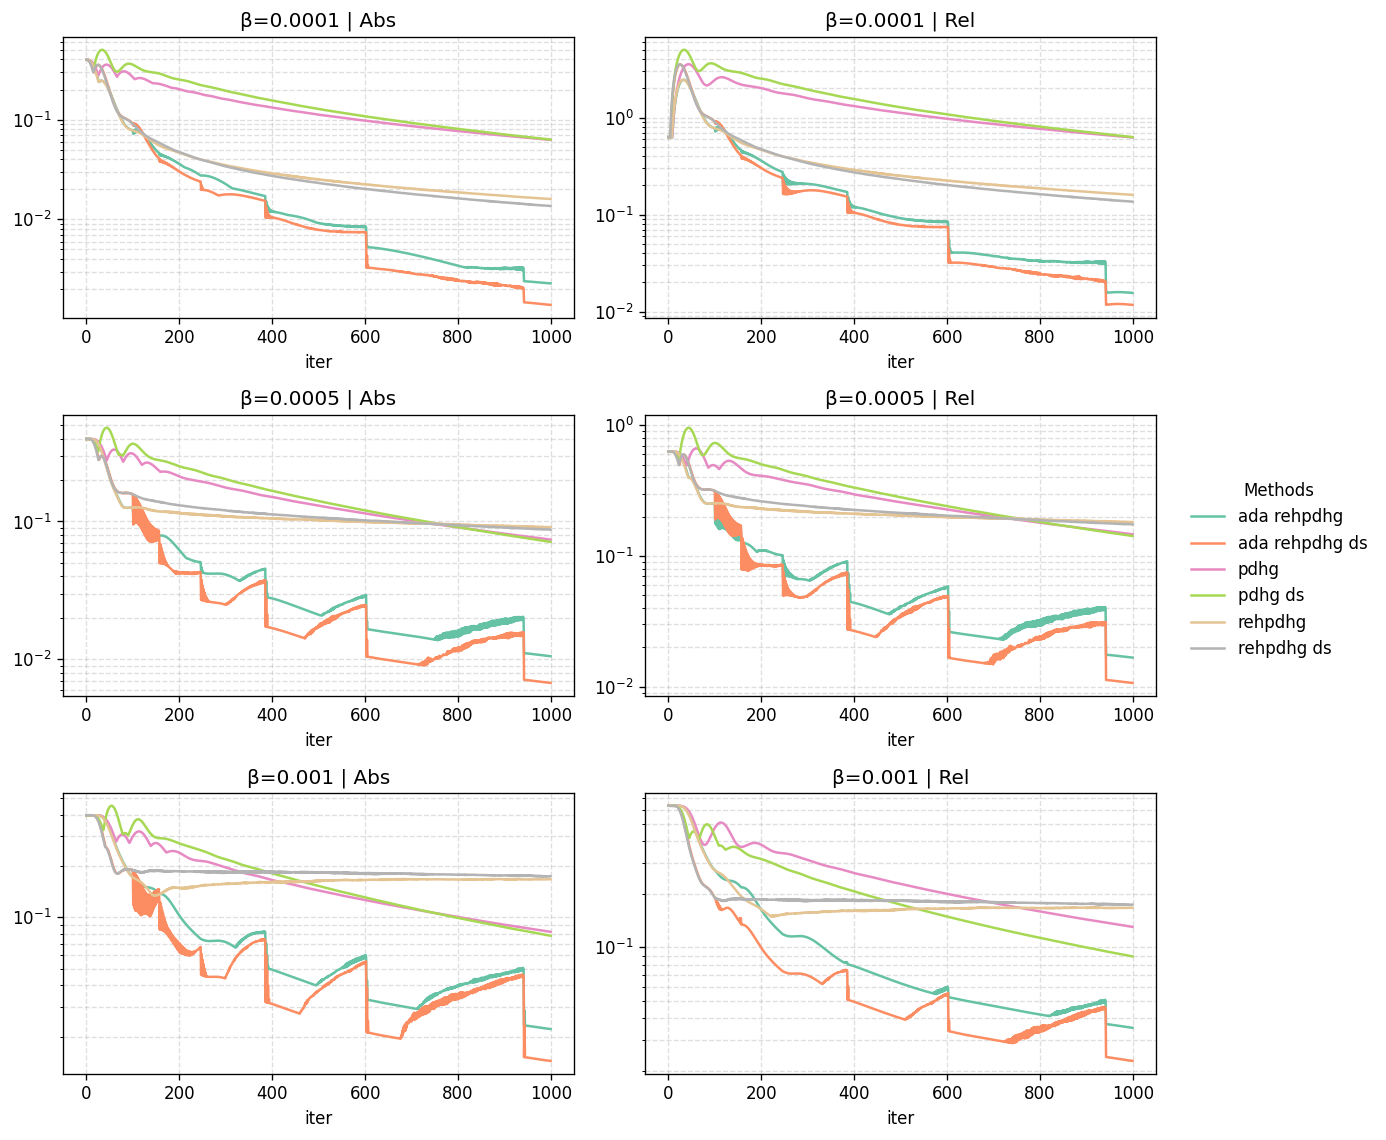

In [18]:
_ = plot_residuals_grid_by_param(residuals, 
                                #  abs_ylim=(1e-3, 5), rel_ylim=(1e-4, 1.5), 
                                 param_name='beta')

#  $m=n=1000$

In [19]:
m = n = 1000
std2 = 0.1
A, B, G1, G2, A_np, B_np, G1_np, G2_np, lamb_max = gaussian_data(m, n, std1=std1, std2=std2, 
                                                                 rank_ratio=rank_ratio, G_in_range=True)


nA = A.pow(2).sum().sqrt().item()
nB = B.pow(2).sum().sqrt().item()
lamb_max = (nA * nA + nB * nB) ** 0.5 
print(f"{mu_reg=:.4e}, {lamb_max=:.4e}")

mu_reg=0.0000e+00, lamb_max=9.9972e+00


In [20]:
residuals = {}
for beta in betas:
    # Torch prox for h* (uses prox_l1 from pdhg.py)
    prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
    h_conj = lambda y: beta * torch.abs(y).sum()
 
    mu_reg = 0
    print(f"{beta=}, {lamb_max=:.4e}")
    residuals[beta] = compare_methods_fast_pdhg(prox_h_conj, h_conj, A, B, G1, G2, beta, mu_reg, f_star=None, 
                            stopping=False, max_iter=max_iter, eps_abs=1e-6)

beta=0.001, lamb_max=9.9972e+00
Method                 Obj          Viol
----------------------------------------
pdhg          -7.851694e-02  9.446561e-02
rehpdhg       -7.858338e-02  3.361043e-02
pdhg ds       -8.680739e-02  8.426018e-02
rehpdhg ds    -8.687732e-02  2.858897e-02
ada rehpdhg   -6.065824e-02  2.158950e-02
ada rehpdhg ds  -7.558116e-02  2.009904e-02
beta=0.0005, lamb_max=9.9972e+00
Method                 Obj          Viol
----------------------------------------
pdhg          -4.410499e-02  1.374200e-01
rehpdhg       -4.418071e-02  4.154809e-02
pdhg ds       -4.644143e-02  1.338174e-01
rehpdhg ds    -4.652164e-02  3.680766e-02
ada rehpdhg   -4.093456e-02  3.212555e-02
ada rehpdhg ds  -4.361166e-02  3.236944e-02
beta=0.0001, lamb_max=9.9972e+00
Method                 Obj          Viol
----------------------------------------
pdhg          -9.730626e-03  4.289503e-01
rehpdhg       -9.805987e-03  6.552812e-02
pdhg ds       -9.847830e-03  4.188573e-01
rehpdhg ds    -9.93091

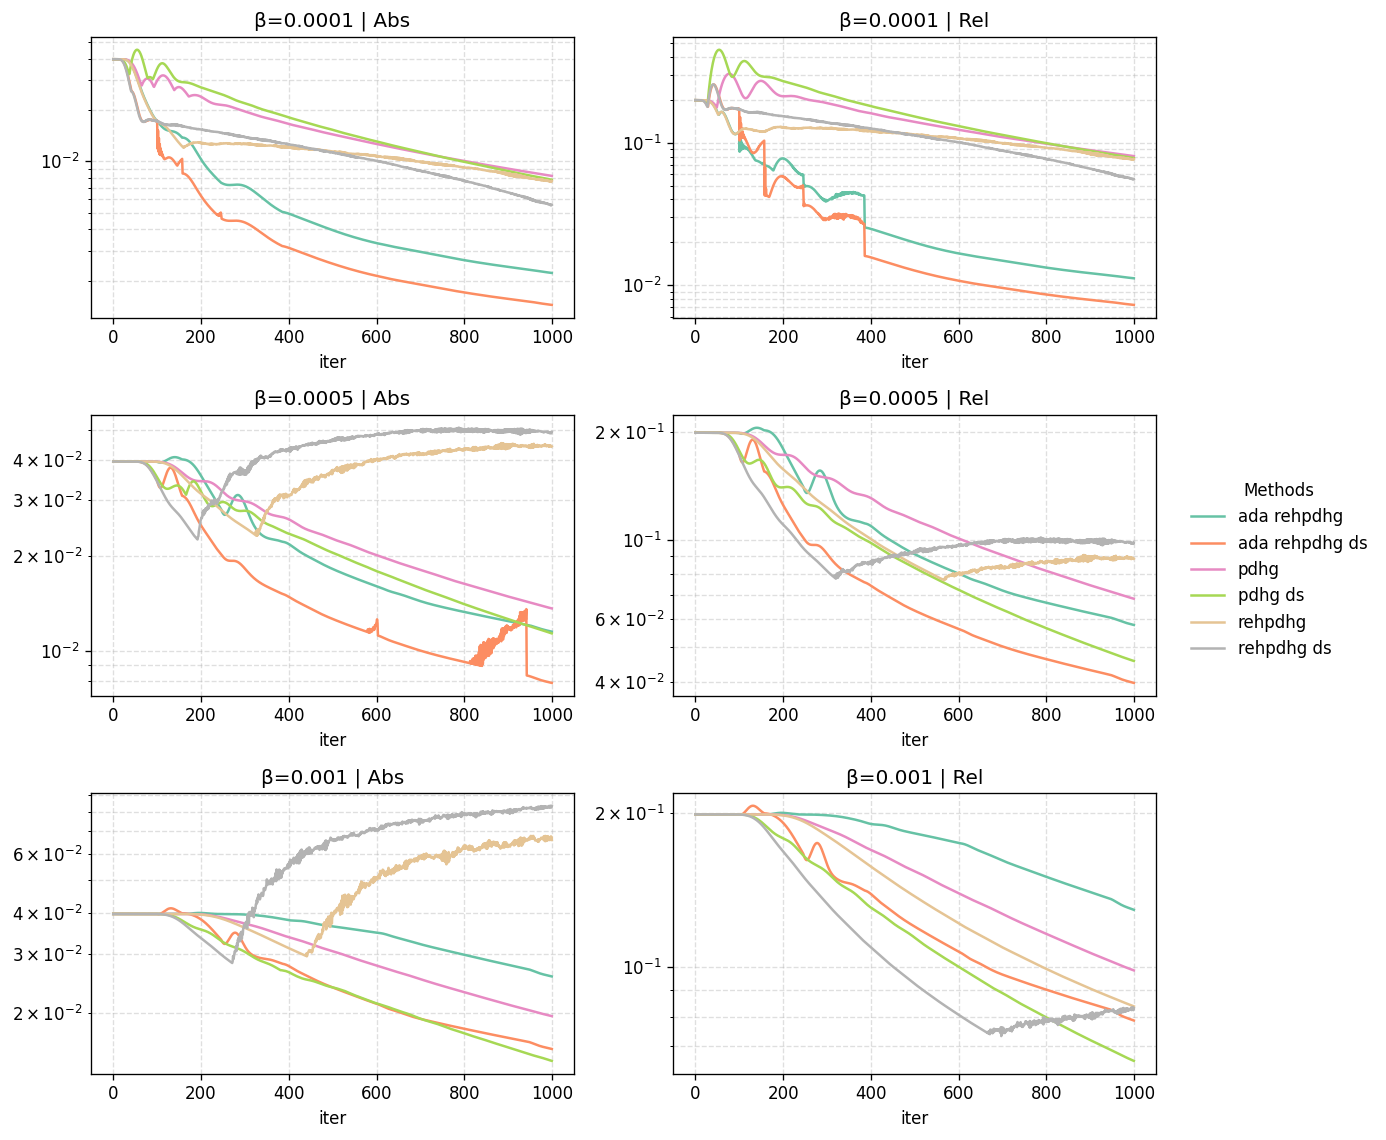

In [21]:
_ = plot_residuals_grid_by_param(residuals,  param_name='beta')